In [1]:
from matplotlib import pyplot as plt
import numpy as np

import os
import cv2

from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler, RMSprop
import torch.nn.functional as F
    
# import utils
from importlib import reload  # Python 3.4+
import addSrcToPath

from dataSaver import DataSaver


import dataloader as __dataloader

reload(__dataloader)

from dataloader import DataProvider

from utils.dice_score import dice_loss

from utils.math import MovingAverage
from utils.tensor import makeDownscaler

# import the time module
import time

In [34]:
def getCheckpointName(modelName, epoch):
  return os.path.join(modelName, f'epochs-{epoch}.pt')

device = "cuda"

annotationsDir = os.path.join('.', 'data', 'coco', 'train2017')
name = 'Yolov8-cocoTest-noise-brighness-colortwicking-counterExamples-d0-test-crl-asym-ld2-s1'
epoch =  4
# name = "Yolov8-cocoTest-noise-brighness-colortwicking-counterExamples-d0-test-lr"
# epoch = 4

modelName = os.path.join('outputs', name)


In [35]:
from model.yolov8.semantic_detection_d0 import Model
import model as _model
reload(_model)
print(_model)
print(epoch)
model = Model(n)
epoch, checkpoint = _model.initialize(model, modelName, n=epoch)
model.to(device);

# Initialize Epoch
currentEpoch = epoch + 1
epochs = 2
print('currentEpoch', currentEpoch)
print('training for:', epochs, 'epochs')

<module 'model' from 'D:\\Projects\\kineticLab\\models\\demo\\src\\model\\__init__.py'>
4
@@@@@ initializing model from checkpoint 4
=> model size: 16.137MB
currentEpoch 5
training for: 2 epochs


In [19]:
model.eval()

purple = [98, 68, 158]
# purple = [107, 90, 203]
tileDx = 256
tileDy = 256

testImages = os.listdir('./test-data')
print(testImages)
# define a video capture object
def openImage(n, yn=0, yi=560, targetColor = [255, 255, 255]):
    path = os.path.join('.','test-data', testImages[n])
    
    imageOriginal = cv2.imread(path)
    yn = imageOriginal.shape[1]
    imageOriginal = imageOriginal[:, yi:yn]

    image = cv2.cvtColor(imageOriginal, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    imageInput = np.abs(cv2.resize(image, [256, 256]) - targetColor)/255
    plt.imshow(imageInput)
    return imageInput, imageOriginal
    

['200pcs-20mm-Colorful-Round-Dots-Paper-Label-Sticker-for-Home-Shop-Decoration-or-School-Office-Files.jpg', 'WIN_20230814_07_27_34_Pro.jpg', 'WIN_20230814_07_27_47_Pro.jpg', 'WIN_20230821_21_06_00_Pro.jpg', 'WIN_20230912_09_03_25_Pro.jpg', 'WIN_20230912_10_46_18_Pro.jpg']


In [20]:
# CPU NMS
def box_area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

def iou(box_a, box_b):
    # Calculate the area of the intersection rectangle
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])

    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)

    # Calculate the area of both rectangles
    box_a_area = box_area(box_a)
    box_b_area = box_area(box_b)

    # Calculate the IoU
    return inter_area / (box_a_area + box_b_area - inter_area)

def nms(boxes, iou_threshold=0.5):
    print('len(boxes)',len(boxes))
    if len(boxes) == 0:
        return []
    # Sort the boxes based on their confidence scores
    boxes = sorted(boxes, key=lambda x: x[1], reverse=True)
    
    picked = [boxes[0]]

    # Pick the box with the highest score and compute its overlap with other boxes
    for j in range(1, len(boxes)):
        
        new_box = boxes[j][2]    
        is_new = True

        for i in range(len(picked)):
            # If the IoU is greater than the threshold, discard the box
            target_box = picked[i][2]
            if iou(target_box, new_box) > iou_threshold:
                is_new = False
                break

        if is_new:
            picked.append(boxes[j])

    return picked

import time
from utils.math import MovingAverage
fps = MovingAverage(1000)
startTime = time.time()
fps.add(time.time() - startTime)

def runDetection(image):
    imageTorch = torch.from_numpy(image)
    imageTorch = imageTorch.to('cuda', dtype=torch.float).unsqueeze(0)
    input = imageTorch.permute(0, 3, 1, 2)

    with torch.no_grad():
        pred, dxdy, wh, __ = model(input)
        pred = pred.squeeze()
        pred = torch.sigmoid(pred)
        
        dxdywhPred = torch.concat([dxdy, wh], dim=1).permute(0, 2, 3, 1)
        
        ltOutput, rbOutput = cxcywhToXyxy(dxdywhPred, anchorTensor)
        ltrbOutput = torch.concat([ltOutput, rbOutput], dim = 3)
        ltrbOutput = ltrbOutput.flatten(start_dim=1, end_dim=2).squeeze()
        
        scores = pred.flatten(start_dim=0, end_dim=1) 
        valid = scores > 0.9
        ltrbOutput = ltrbOutput[valid]
        scores = scores[valid]

    return pred.cpu().numpy(), ltrbOutput.cpu().numpy(), scores.cpu().numpy()


In [40]:
targetColor=[126, 87, 192]
targetColorBlue = [30, 64, 208]

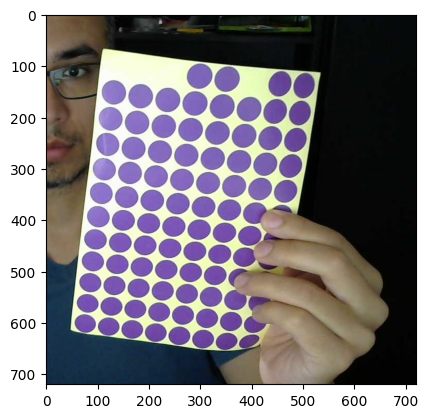

clss (1657, 4)
scores (1657,)
len(boxes) 1657


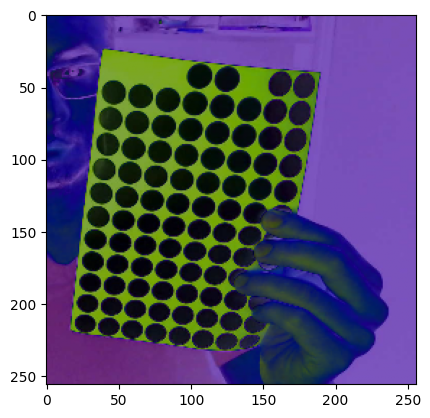

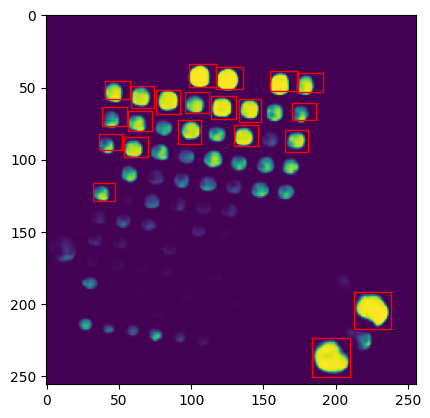

In [42]:
from matplotlib.patches import Rectangle
from utils.tensor import locTensor, cxcywhToXyxy
anchorTensor = locTensor(1, 256)

# inputImage, originalImage = openImage(1, yi = 560, targetColor=[126, 87, 192])
# inputImage, originalImage = openImage(4, yi = 560, targetColor=detected)
inputImage, imageOriginal = openImage(4, yi = 560, targetColor=targetColor)
# inputImage, imageOriginal= openImage(0, yi = 0, targetColor = targetColorBlue)

clss, xyxy, scores = runDetection(inputImage)

print('clss', xyxy.shape)
print('scores', scores.shape)

# cv2.imshow('frame', imageUnstacked.cpu().numpy())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(clss)
boxes = nms(list(zip(scores, scores, xyxy)), iou_threshold=0.10)

for box in boxes:
    box = box[2]
    x1 = box[0]
    y1 = box[1]
    w = box[2] - box[0]
    h = box[3] - box[1]
    rect = Rectangle((y1, x1), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


# print(dxdy.shape, dxdy.shape)